<a href="https://colab.research.google.com/github/Abdullah-bcu/ghani/blob/main/final_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 58 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   word_freq_make              4601 non-null   float64
 1   word_freq_address           4601 non-null   float64
 2   word_freq_all               4601 non-null   float64
 3   word_freq_3d                4601 non-null   float64
 4   word_freq_our               4601 non-null   float64
 5   word_freq_over              4601 non-null   float64
 6   word_freq_remove            4601 non-null   float64
 7   word_freq_internet          4601 non-null   float64
 8   word_freq_order             4601 non-null   float64
 9   word_freq_mail              4601 non-null   float64
 10  word_freq_receive           4601 non-null   float64
 11  word_freq_will              4601 non-null   float64
 12  word_freq_people            4601 non-null   float64
 13  word_freq_r

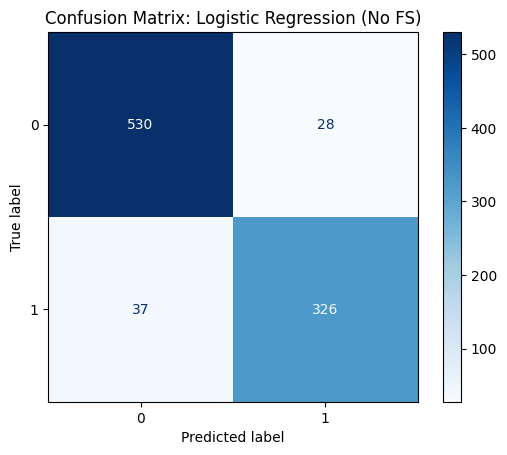

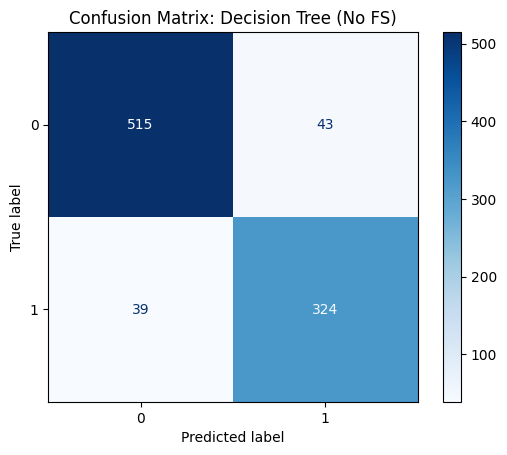

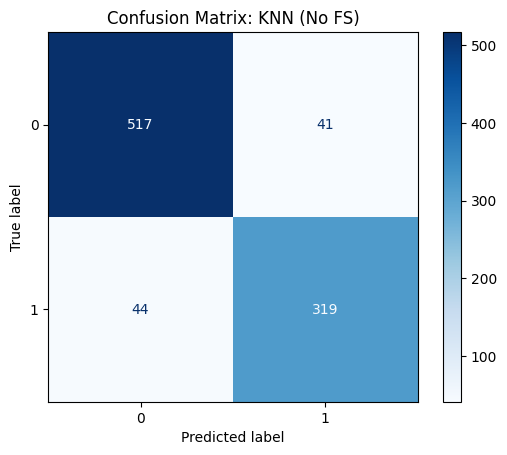

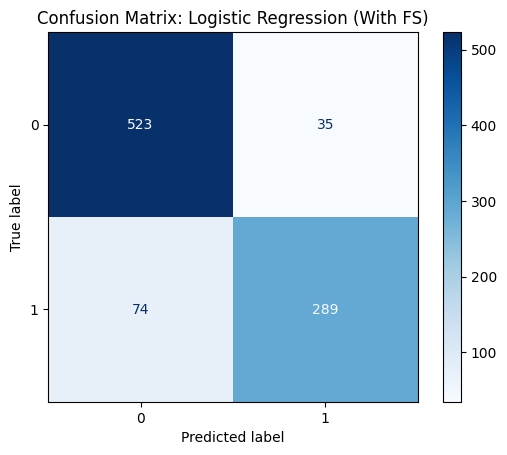

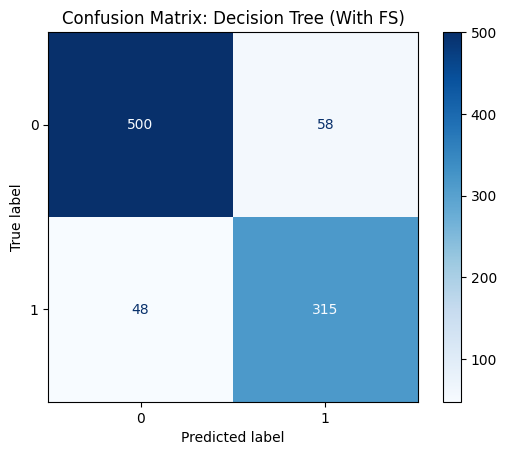

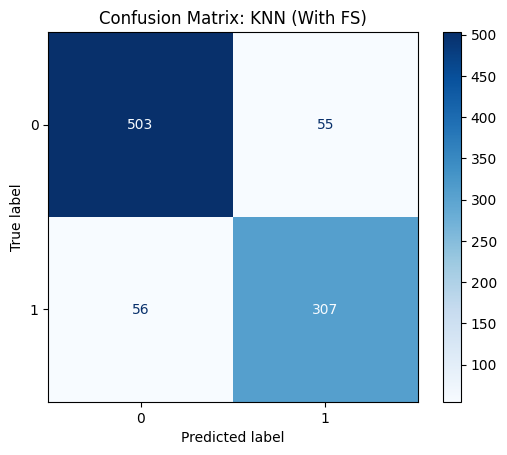


Quick Summary:
                               Accuracy  F1-Score    Time
Logistic Regression (No FS)      0.9294    0.9093  0.3514
Decision Tree (No FS)            0.9110    0.8877  0.4033
KNN (No FS)                      0.9077    0.8824  0.0025
Logistic Regression (With FS)    0.8817    0.8413  0.0288
Decision Tree (With FS)          0.8849    0.8560  0.0574
KNN (With FS)                    0.8795    0.8469  0.0455


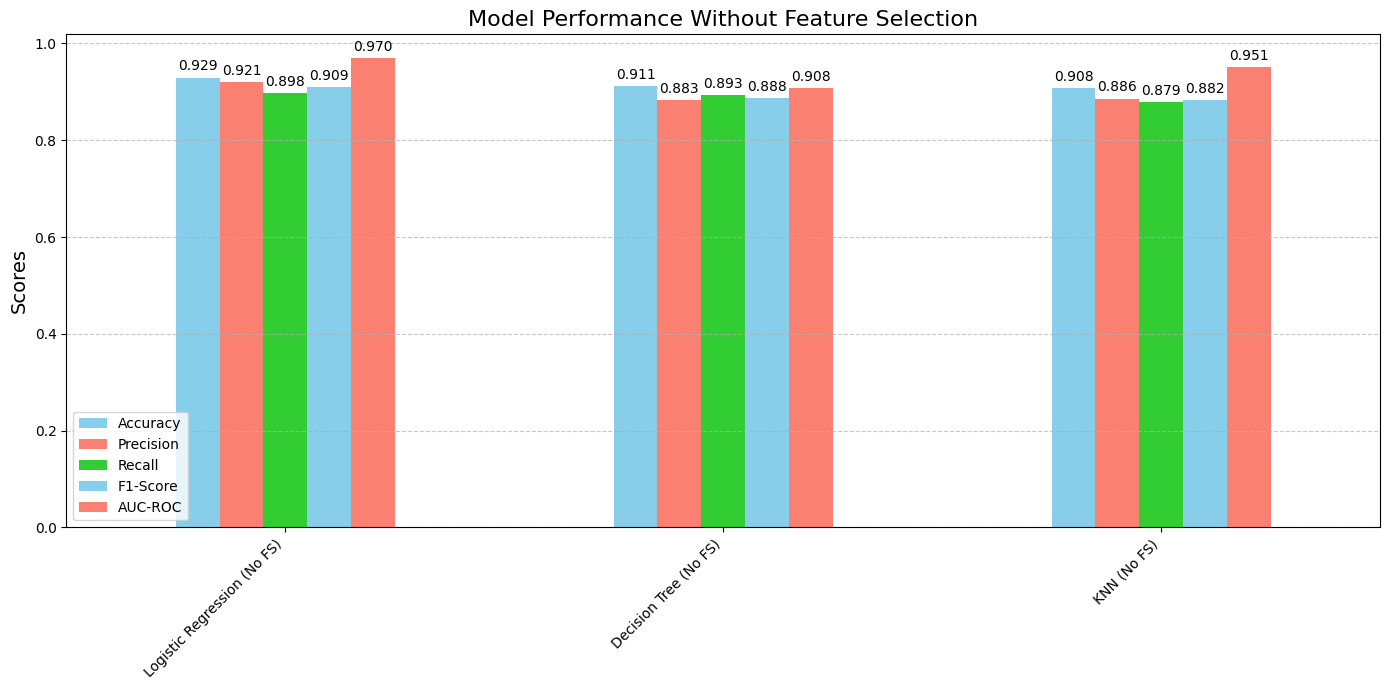

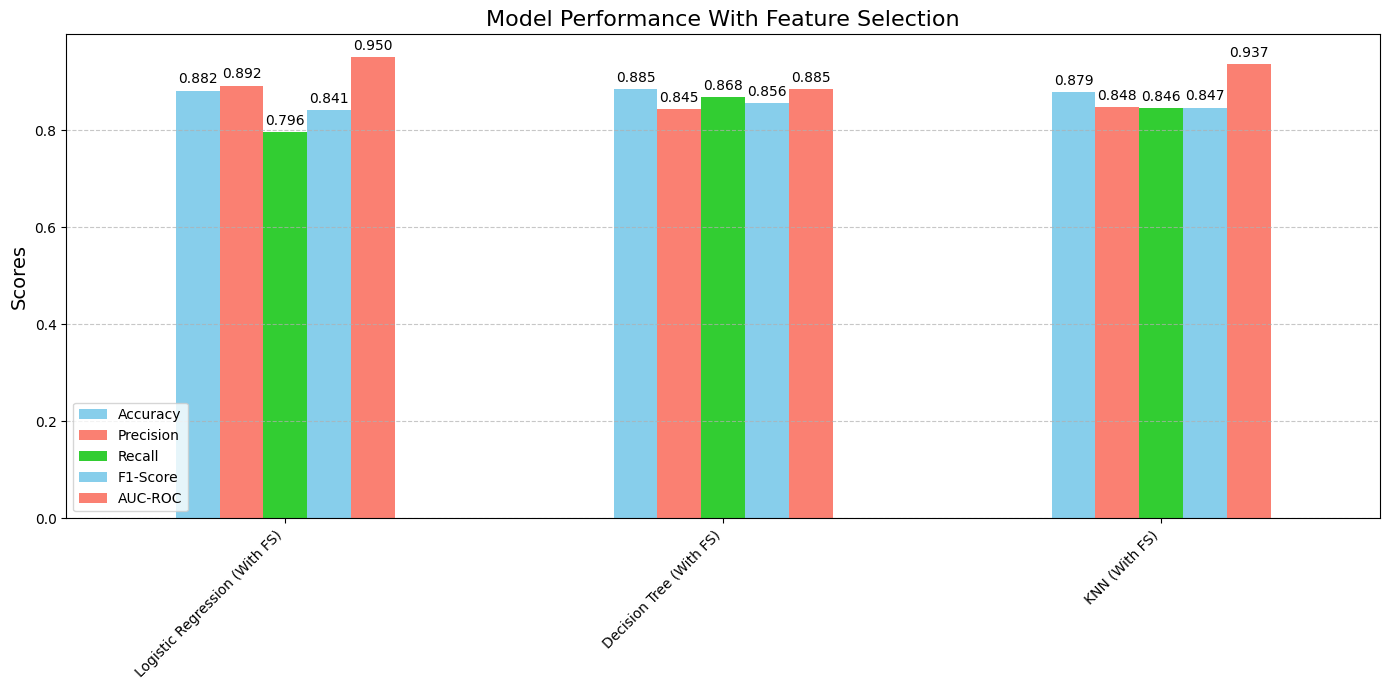

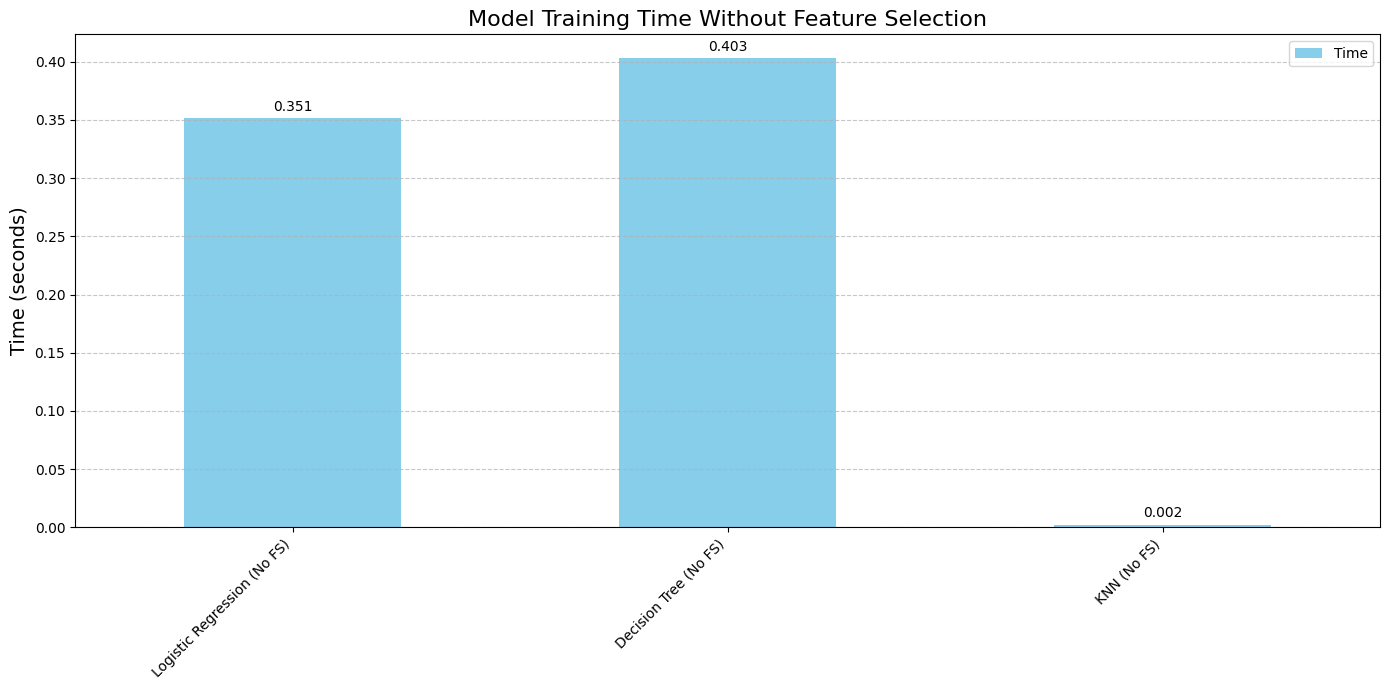

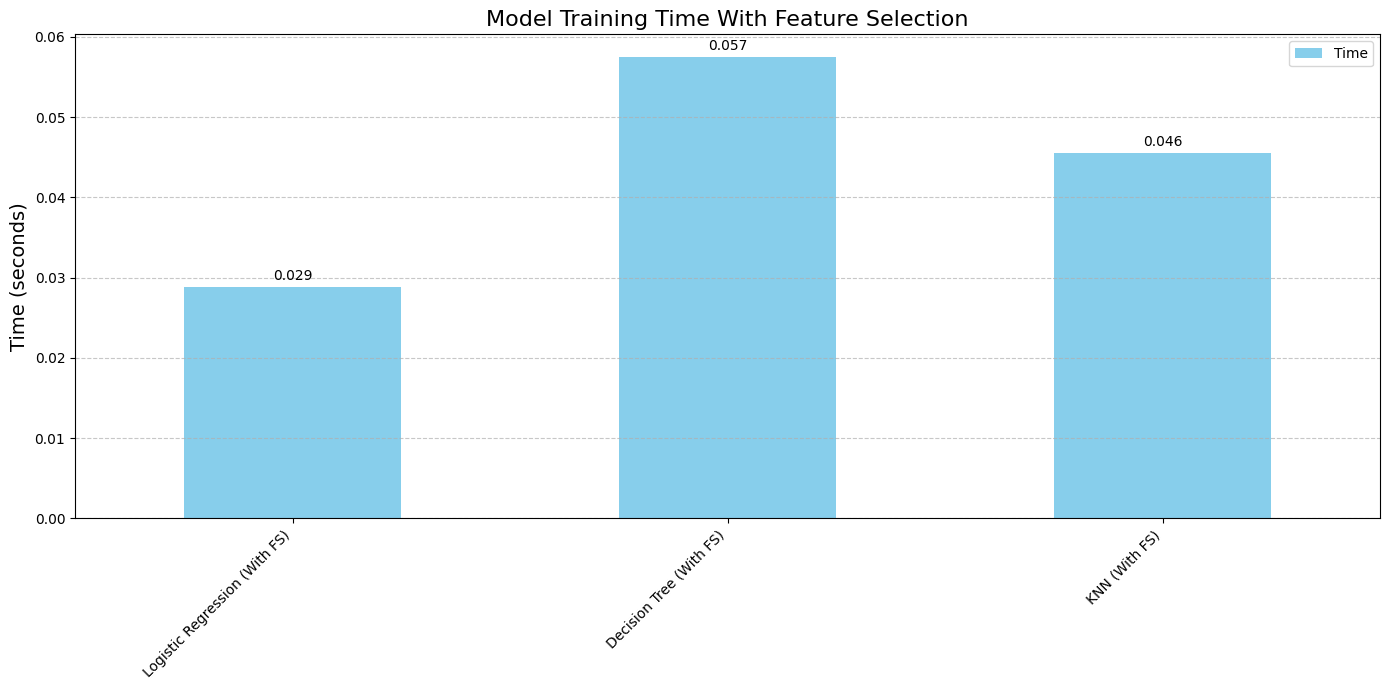

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Load the dataset
df = pd.read_csv('Spam Detection .csv')

print("\n--- Dataset Info ---")
df.info()
print("\n--- Statistical Summary ---")
print(df.describe())
print("\n--- Spam Class Distribution ---")
print(df['spam'].value_counts())

X = df.drop('spam', axis=1)
y = df['spam']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature selection
k_features = 10
selector = SelectKBest(chi2, k=k_features)
X_train_kbest = selector.fit_transform(X_train, y_train)
X_test_kbest = selector.transform(X_test)

# Scaling after feature selection
scaler_fs = StandardScaler()
X_train_kbest_scaled = scaler_fs.fit_transform(X_train_kbest)
X_test_kbest_scaled = scaler_fs.transform(X_test_kbest)

data_sets = {
    "without_fs": {"X_train": X_train_scaled, "X_test": X_test_scaled},
    "with_fs": {"X_train": X_train_kbest_scaled, "X_test": X_test_kbest_scaled},
}

def evaluate_model(model, X_train_data, X_test_data, y_train_data, y_test_data, title):
    start_time = time.time()
    model.fit(X_train_data, y_train_data)
    elapsed_time = time.time() - start_time

    y_pred = model.predict(X_test_data)
    y_prob = model.predict_proba(X_test_data)[:, 1] if hasattr(model, 'predict_proba') else None

    # Confusion Matrix
    cm = confusion_matrix(y_test_data, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix: {title}")
    plt.show()

    metrics = {
        'Accuracy': accuracy_score(y_test_data, y_pred),
        'Precision': precision_score(y_test_data, y_pred),
        'Recall': recall_score(y_test_data, y_pred),
        'F1-Score': f1_score(y_test_data, y_pred),
        'AUC-ROC': roc_auc_score(y_test_data, y_prob) if y_prob is not None else np.nan,
        'Time': elapsed_time
    }
    return metrics

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
}

# Evaluate models
results = {}
for name, model in models.items():
    metrics = evaluate_model(model, data_sets["without_fs"]["X_train"],
                             data_sets["without_fs"]["X_test"],
                             y_train, y_test,
                             title=f"{name} (No FS)")
    results[f"{name} (No FS)"] = metrics

for name, model in models.items():
    metrics = evaluate_model(model, data_sets["with_fs"]["X_train"],
                             data_sets["with_fs"]["X_test"],
                             y_train, y_test,
                             title=f"{name} (With FS)")
    results[f"{name} (With FS)"] = metrics

results_df = pd.DataFrame(results).T
results_df.columns = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'Time']
print("\nQuick Summary:")
print(results_df[['Accuracy', 'F1-Score', 'Time']].round(4))

# Plotting results with separate bar charts and distinct colors
def plot_performance(results_df, title, ylabel='Scores'):
    ax = results_df.plot(kind='bar', figsize=(14, 7), color=['skyblue', 'salmon', 'limegreen'])
    plt.title(title, fontsize=16)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(loc='best')

    # Add values on top of bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=3)

    plt.tight_layout()
    plt.show()

# Separate results for visualization
results_no_fs = results_df.loc[[idx for idx in results_df.index if "No FS" in idx]]
results_with_fs = results_df.loc[[idx for idx in results_df.index if "With FS" in idx]]

# Plot performance without and with feature selection separately
plot_performance(results_no_fs.drop('Time', axis=1), "Model Performance Without Feature Selection")
plot_performance(results_with_fs.drop('Time', axis=1), "Model Performance With Feature Selection")

# Plot execution time comparison separately
plot_performance(results_no_fs[['Time']], "Model Training Time Without Feature Selection", ylabel='Time (seconds)')
plot_performance(results_with_fs[['Time']], "Model Training Time With Feature Selection", ylabel='Time (seconds)')